In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, cv2, json
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_filter, zoom
import tensorflow_hub as hub
import PIL
from PIL.ImageDraw import Draw
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

BATCH_SIZE = 16

# **Introduction**

In this project, we aim to build a deep learning model for crowd counting using CSRNet. The goal is to accurately estimate the number of people in images captured from surveillance cameras. This will help city planners monitor crowd density, prevent overcrowding, and ensure public safety during large events, such as festivals or public gatherings.

# **Business Understanding**

The city of Nusantara is preparing for the **Festival Harmoni Nusantara**, which is expected to attract hundreds of thousands of visitors. Monitoring crowd density is crucial to prevent overcrowding, manage traffic, and ensure public safety. Abi, a city planning officer, needs a reliable way to **estimate crowd numbers from camera images** in real time. By developing a deep learning-based crowd counting model, the city can:

* Identify areas of high crowd density.
* Optimize evacuation routes if needed.
* Improve planning and resource allocation for large events.
* Ensure a safer and more enjoyable experience for visitors.

The AI model will provide actionable insights to support **smart city management** and prevent potential safety hazards during large-scale events.


# **Data Understanding**

For this project, we use a dataset consisting of **images and corresponding annotations** that indicate the location of people in the scene. Each image represents a crowded area, similar to what might be captured during large events like festivals. The dataset includes:

* **Images**: RGB images of varying resolutions showing crowds in different environments.
* **Annotations**: JSON files containing coordinates (x, y) for each person in the image. These points are used to generate **density maps** for training the model.
* **Train/Test Split**: The dataset is divided into training and testing sets to evaluate the model’s performance on unseen data.

Understanding the structure of the images and annotations is crucial, as the CSRNet model learns to predict **density maps**, which are then summed to estimate the total number of people in each image.



# **Extract Dataset**

In [3]:
train_images_dir = "/content/drive/MyDrive/Hology/crowd_data/train/images"
train_labels_dir = "/content/drive/MyDrive/Hology/crowd_data/train/labels"
test_images_dir = "/content/drive/MyDrive/Hology/crowd_data/test/images"

In [4]:
label_files = [f for f in os.listdir(train_labels_dir) if f.endswith('.json')]
label_path = os.path.join(train_labels_dir, label_files[0])

with open(label_path, 'r') as f:
    data = json.load(f)

img_id = data['img_id']
human_num = data['human_num']
points = data['points']

img_path = os.path.join(train_images_dir, img_id)
image = Image.open(img_path).convert("RGB")

# random debugging
print(f"Successfully loaded image: {img_id}")
print(f"Number of people (ground truth): {human_num}")

Successfully loaded image: 1809.jpg
Number of people (ground truth): 65


# **Exploratory Data Analysis**

## ***Sample Image***

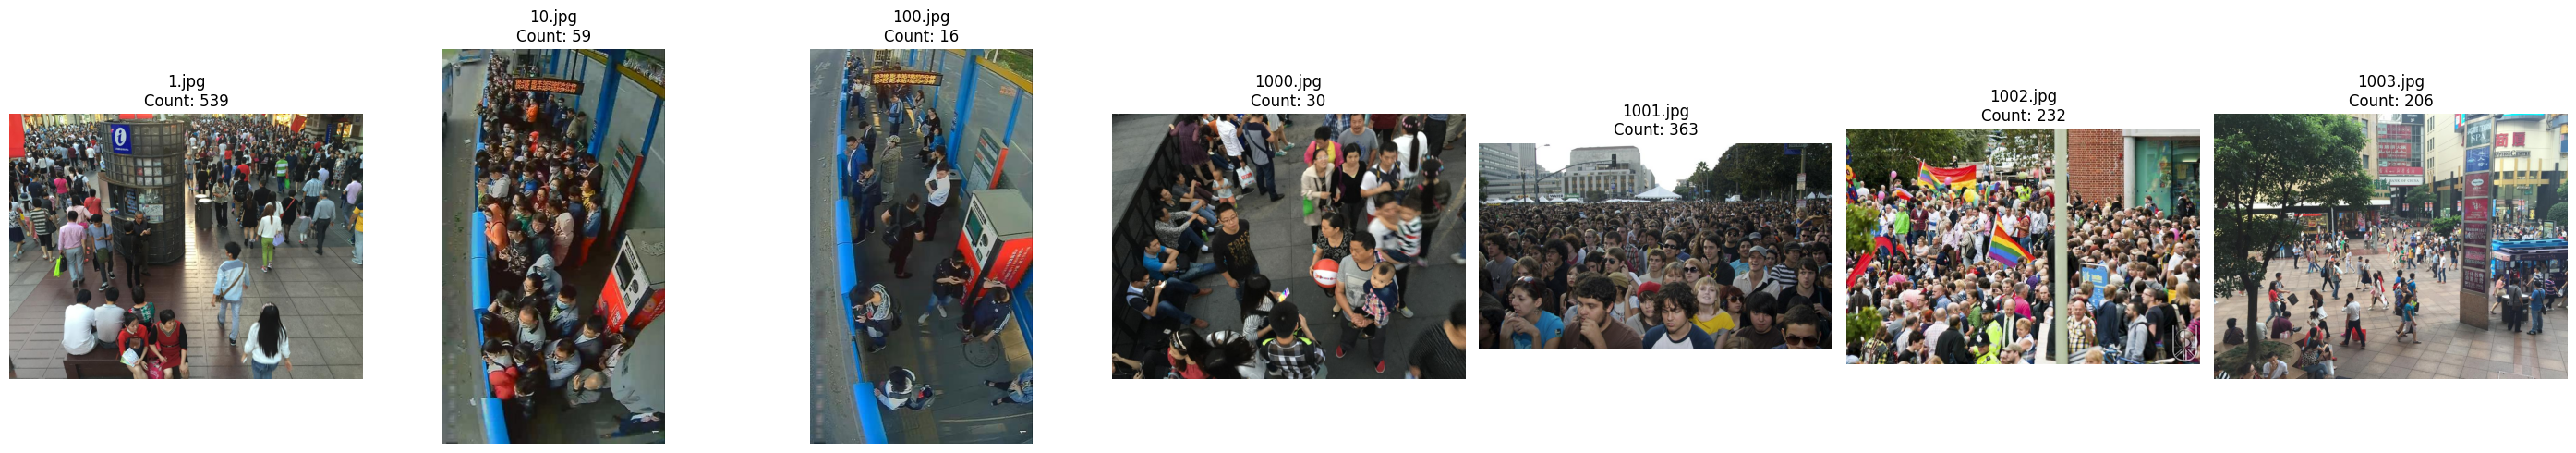

In [5]:
def show_samples(img_dir, label_dir, n=5, show_points=False):
    img_names = sorted(os.listdir(img_dir))[:n]
    plt.figure(figsize=(4*n, 5))

    for i, img_name in enumerate(img_names):
        # load image
        img_path = os.path.join(img_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # load label
        label_path = os.path.join(label_dir, img_name.replace(".jpg", ".json"))
        with open(label_path, "r") as f:
            data = json.load(f)
        count = data["human_num"]

        if show_points:
            for (x, y) in data["points"]:
                cv2.circle(img, (int(x), int(y)), 3, (255, 0, 0), -1)

        # plot
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"{img_name}\nCount: {count}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_samples(train_images_dir, train_labels_dir, n=7, show_points=False)

## ***Density Map***

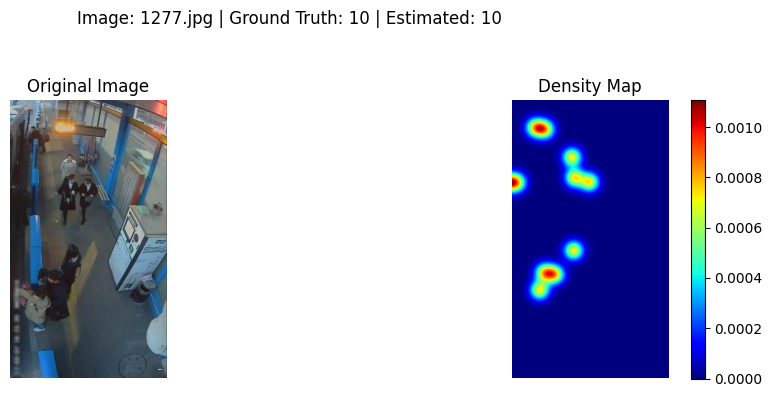

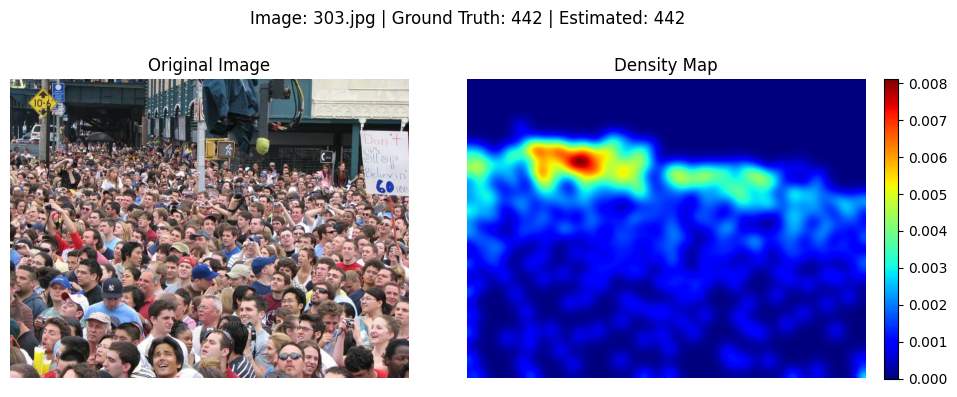

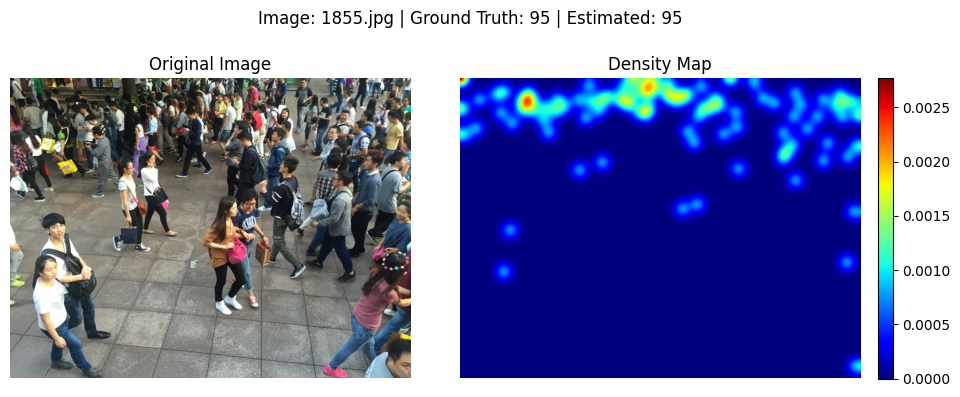

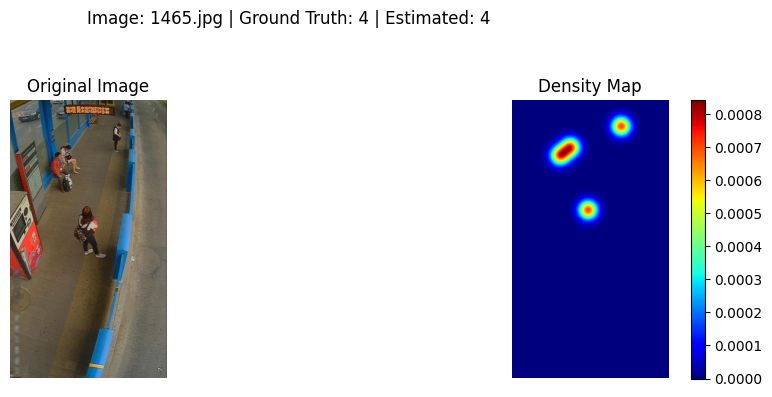

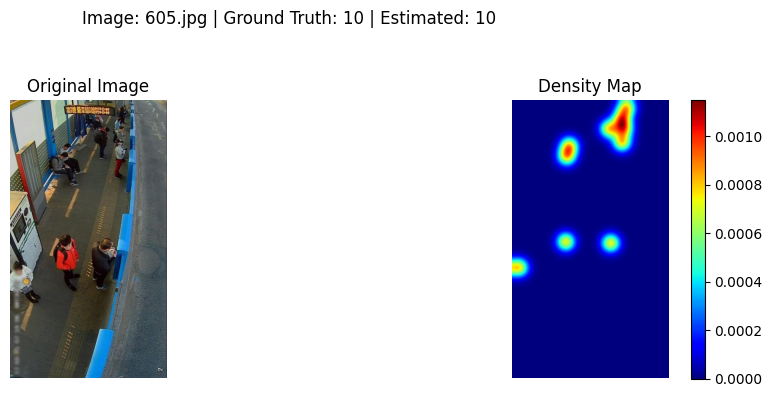

In [6]:
# build annotations dictionary from all JSON label files
def load_annotations(labels_dir):
    annotations = {}
    label_files = [f for f in os.listdir(labels_dir) if f.endswith('.json')]

    for lf in label_files:
        path = os.path.join(labels_dir, lf)
        with open(path, 'r') as f:
            data = json.load(f)
        img_id = data['img_id']
        points = data['points']
        annotations[img_id] = points
    return annotations

def visualize_random_density_maps(image_dir, annotations, n_images=5, sigma=15):
    image_files = [f for f in os.listdir(image_dir) if f in annotations]
    selected_files = random.sample(image_files, min(n_images, len(image_files)))

    for img_file in selected_files:
        img_path = os.path.join(image_dir, img_file)
        image = np.array(Image.open(img_path).convert("RGB"))
        points = annotations.get(img_file, [])

        height, width = image.shape[:2]
        density_map = np.zeros((height, width), dtype=np.float32)

        if points:
            coords = np.array([(p['x'], p['y']) for p in points])
            for x, y in coords:
                x, y = int(x), int(y)
                if 0 <= y < height and 0 <= x < width:
                    density_map[y, x] = 1.0

            density_map = gaussian_filter(density_map, sigma=sigma)
            density_map = density_map / (density_map.sum() + 1e-8) * len(points)

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        im = plt.imshow(density_map, cmap="jet")
        plt.title("Density Map")
        plt.axis("off")
        plt.colorbar(im, fraction=0.046, pad=0.04)

        est_count = density_map.sum()
        plt.suptitle(
            f"Image: {img_file} | Ground Truth: {len(points)} | Estimated: {est_count:.0f}",
            fontsize=12
        )
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()

annotations = load_annotations(train_labels_dir)
visualize_random_density_maps(train_images_dir, annotations, n_images=5)


The output shows:

* **Ground truth count** = the actual number of people from JSON (`len(points)`).
* **Estimated count** = `density_map.sum()`, which is our density map's prediction of how many people there are.
<br>


The **estimated count** comes from summing all pixel values in the density map. Each head annotation is first placed as a point, then blurred with a Gaussian filter to create a smooth “blob” of density. After this, we normalize so that the total sum of the density map matches the number of people (ground truth). This way, the density map not only shows *where* people are located but also ensures that its pixel values add up to the correct count. Later, when we train the model, it will predict density maps directly, and the sum of those predicted maps will be our estimated crowd count.
?


In [7]:
def create_density_map(points, img_shape):
    height, width = img_shape[1], img_shape[0]
    density_map = np.zeros((height, width), dtype=np.float32)

    if not points:
        return density_map
    coords = np.array([(p['x'], p['y']) for p in points])
    for x, y in coords:
        x, y = int(x), int(y)
        if 0 <= y < height and 0 <= x < width:
            density_map[y, x] = 1.0
    sigma = 15
    density_map = gaussian_filter(density_map, sigma=sigma)
    density_map = density_map / (density_map.sum() + 1e-8) * len(points)

    return density_map

density_map = create_density_map(points, image.size)
print(f"Density map sum (random pick): {density_map.sum():.2f}")

Density map sum (random pick): 65.00


## ***Human Distribution***

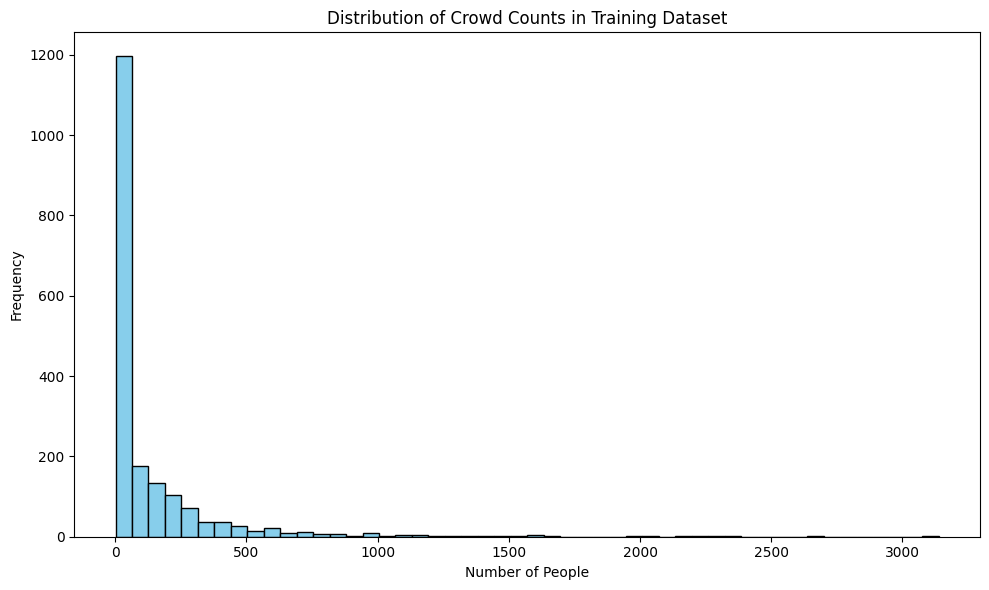


--- Statistics ---
Total images: 1900
Minimum people in an image: 1
Maximum people in an image: 3139
Average people per image: 138.90
Median people per image: 28.00


In [8]:
human_counts = []
label_files = [f for f in os.listdir(train_labels_dir) if f.endswith('.json')]

# collect human counts from all label files
for label_file in label_files:
    label_path = os.path.join(train_labels_dir, label_file)
    with open(label_path, 'r') as f:
        data = json.load(f)
        human_counts.append(data['human_num'])

plt.figure(figsize=(10, 6))
plt.hist(human_counts, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Crowd Counts in Training Dataset')
plt.xlabel('Number of People')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("\n--- Statistics ---")
print(f"Total images: {len(human_counts)}")
print(f"Minimum people in an image: {np.min(human_counts)}")
print(f"Maximum people in an image: {np.max(human_counts)}")
print(f"Average people per image: {np.mean(human_counts):.2f}")
print(f"Median people per image: {np.median(human_counts):.2f}")


The dataset has 1,900 training images with a wide range of crowd sizes. The smallest image has just 1 person, while the largest has over 3,000 people. On average, each image contains about 139 people, but the median is only 28, which means most images have relatively small crowds and only a few images have very large crowds. This shows the dataset is highly imbalanced, with many sparse scenes and some extremely dense ones.

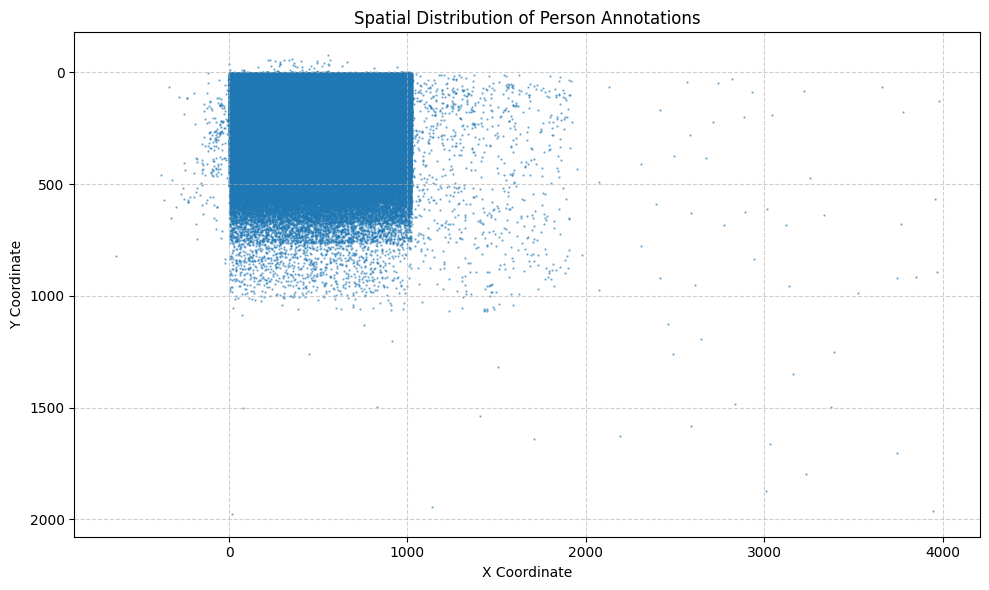

In [9]:
# spatial distribution of person annotations across the dataset.
def plot_spatial_distribution(label_dir, sample_limit=None):
    x_coords = []
    y_coords = []

    label_files = [f for f in os.listdir(label_dir) if f.endswith('.json')]
    if sample_limit:
        label_files = label_files[:sample_limit]

    for label_file in label_files:
        label_path = os.path.join(label_dir, label_file)
        with open(label_path, 'r') as f:
            data = json.load(f)
            for point in data['points']:
                x_coords.append(point['x'])
                y_coords.append(point['y'])

    plt.figure(figsize=(10, 6))
    plt.scatter(x_coords, y_coords, s=0.5, alpha=0.5)
    plt.gca().invert_yaxis()  # match image coordinate system
    plt.title('Spatial Distribution of Person Annotations')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


plot_spatial_distribution(train_labels_dir, sample_limit=None)

The plot shows that most person annotations are concentrated in a rectangular area around the top-left to middle part of the images, meaning people usually appear in that region. Only a few annotations are scattered outside this area, showing that people rarely appear elsewhere. This strong positional bias **may also be influenced by differences in image resolution and aspect ratios**, which cause coordinates to vary across the dataset.

## ***Resolution***

Unique sizes found: 224
Size (360, 640): 943 images
Size (1024, 768): 569 images
Size (1920, 1080): 67 images
Size (1024, 683): 31 images
Size (1024, 681): 15 images
Size (1280, 720): 7 images
Size (1024, 684): 5 images
Size (1024, 680): 5 images
Size (1024, 576): 5 images
Size (1024, 687): 4 images


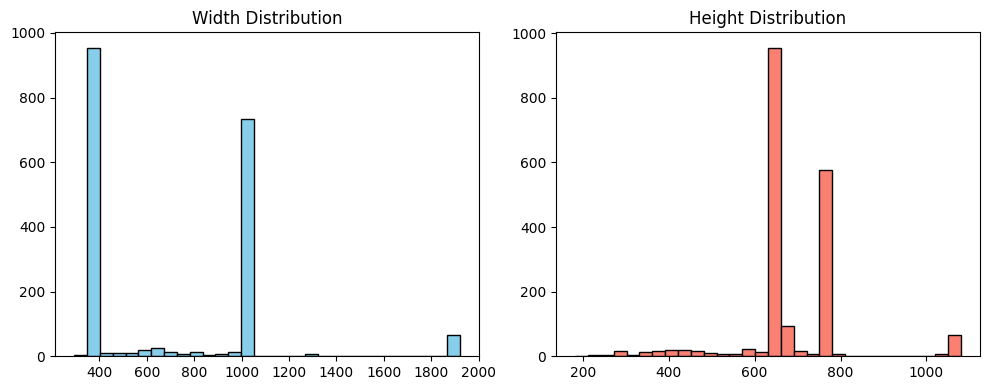

In [10]:
# distribution of image sizes (width x height)
def display_image_size_distribution(image_dir):
    from collections import Counter

    sizes = []
    image_files = [f for f in os.listdir(image_dir)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for img_file in image_files:
        try:
            img_path = os.path.join(image_dir, img_file)
            with Image.open(img_path) as img:
                sizes.append(img.size)  # (width, height)
        except Exception as e:
            print(f"Error reading {img_file}: {e}")

    if not sizes:
        print("No images found.")
        return

    # count unique sizes
    size_counts = Counter(sizes)
    print(f"Unique sizes found: {len(size_counts)}")
    for size, count in size_counts.most_common(10):
        print(f"Size {size}: {count} images")

    # plot distribution of widths and heights separately
    widths, heights = zip(*sizes)
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=30, color="skyblue", edgecolor="black")
    plt.title("Width Distribution")

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=30, color="salmon", edgecolor="black")
    plt.title("Height Distribution")

    plt.tight_layout()
    plt.show()

display_image_size_distribution(train_images_dir)

The result shows that your dataset has **224 unique image sizes**, with the majority being **360×640 (943 images)** and **1024×768 (569 images)**, while the rest are spread across many other resolutions like 1920×1080, 1280×720, and several close variants of 1024px width. Since the images are not consistent in size, this can cause issues when training a deep learning model, as models require a fixed input shape. Later, we will need to **preprocess the images by resizing or scaling them** to a uniform size so that the dataset becomes consistent and ready for training.

## ***Unique Data Types***

In [11]:
# check the data types of all images in the directory
def get_image_data_types(directory):
    image_data_types = set()

    for image_name in os.listdir(directory):
        if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        image_path = os.path.join(directory, image_name)
        try:
            img = Image.open(image_path).convert("RGB")  # ensure consistent mode
            img_array = np.array(img)
            image_data_types.add(img_array.dtype)
        except Exception as e:
            print(f"Error processing {image_name}: {e}")

    return image_data_types

IMAGE_DIR = train_images_dir
image_data_types = get_image_data_types(IMAGE_DIR)
print("Image data types in the folder:", image_data_types)

Image data types in the folder: {dtype('uint8')}


Images are stored with pixel values from **0 to 255**. Each number shows how bright or dark a pixel is, and this is the standard way most images are saved.

## ***RGB Distribution***

Total images analyzed: 1900
Grayscale: 15
RGB: 1885


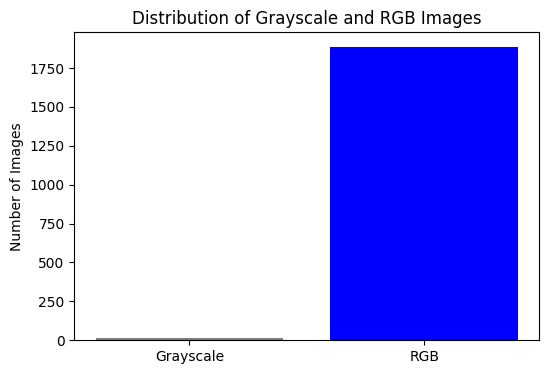

In [12]:
# display distribution of grayscale vs RGB images
def display_image_type_distribution_simple(image_dir):
    grayscale_count = 0
    rgb_count = 0

    # only take image files
    image_files = [f for f in os.listdir(image_dir)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for img_file in image_files:
        image_path = os.path.join(image_dir, img_file)
        try:
            img = mpimg.imread(image_path)

            # grayscale images have shape (H, W) --> 2D
            if len(img.shape) == 2:
                grayscale_count += 1
            # rGB images have shape (H, W, 3) --> 3D
            elif len(img.shape) == 3 and img.shape[2] == 3:
                rgb_count += 1
        except Exception as e:
            print(f"Error reading {img_file}: {e}")

    print(f"Total images analyzed: {len(image_files)}")
    print(f"Grayscale: {grayscale_count}")
    print(f"RGB: {rgb_count}")

    plt.figure(figsize=(6, 4))
    plt.bar(['Grayscale', 'RGB'], [grayscale_count, rgb_count],
            color=['gray', 'blue'])
    plt.title('Distribution of Grayscale and RGB Images')
    plt.ylabel('Number of Images')
    plt.show()

# use training images
display_image_type_distribution_simple(train_images_dir)

We can see that not all images in the dataset were saved in the same format. Most are stored in **RGB (3 color channels: red, green, blue)**, but a few (15 images) were saved as **grayscale (1 channel)**.

Reasons this happens:

* Some original crowd images were captured in black and white or saved that way.
* Certain preprocessing or annotation tools may have converted them to grayscale.


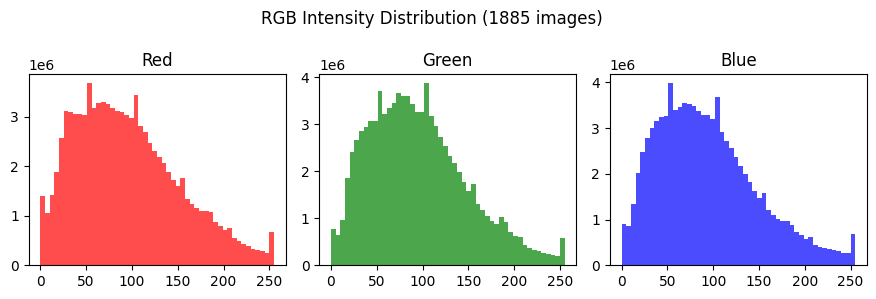


-- Avg Red per Image --
Mean: 94.99
Median: 87.74
Std Dev: 23.09
Min: 45.58
Max: 181.16

-- Avg Green per Image --
Mean: 95.09
Median: 88.73
Std Dev: 19.80
Min: 41.95
Max: 169.09

-- Avg Blue per Image --
Mean: 93.26
Median: 89.28
Std Dev: 19.74
Min: 19.58
Max: 162.75


In [13]:
def display_avg_rgb_histogram(image_dir, n_images=10, img_size=(224, 224)):
    image_files = [f for f in os.listdir(image_dir)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    selected_images = random.sample(image_files, min(n_images, len(image_files)))

    per_image_r_means, per_image_g_means, per_image_b_means = [], [], []
    all_r, all_g, all_b = [], [], []

    for img_file in selected_images:
        image_path = os.path.join(image_dir, img_file)
        img = mpimg.imread(image_path)

        if img.ndim != 3 or img.shape[2] != 3:
            continue

        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)

        if img.shape[:2] != img_size:
            img = np.array(Image.fromarray(img).resize(img_size))

        r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]

        # per-image means
        per_image_r_means.append(r.mean())
        per_image_g_means.append(g.mean())
        per_image_b_means.append(b.mean())

        all_r.append(r.flatten())
        all_g.append(g.flatten())
        all_b.append(b.flatten())

    if not per_image_r_means:
        print("No RGB images found in the selected sample.")
        return

    all_r = np.concatenate(all_r)
    all_g = np.concatenate(all_g)
    all_b = np.concatenate(all_b)

    # plot histograms
    plt.figure(figsize=(9, 3))
    plt.suptitle(f"RGB Intensity Distribution ({len(per_image_r_means)} images)")

    for i, (channel, data, color) in enumerate(
        zip(["Red", "Green", "Blue"], [all_r, all_g, all_b], ["red", "green", "blue"])
    ):
        plt.subplot(1, 3, i+1)
        plt.hist(data, bins=50, color=color, alpha=0.7)
        plt.title(channel)

    plt.tight_layout()
    plt.show()

    # print stats
    def print_stats(name, values):
        print(f"\n-- Avg {name} per Image --")
        print(f"Mean: {np.mean(values):.2f}")
        print(f"Median: {np.median(values):.2f}")
        print(f"Std Dev: {np.std(values):.2f}")
        print(f"Min: {np.min(values):.2f}")
        print(f"Max: {np.max(values):.2f}")

    print_stats("Red", per_image_r_means)
    print_stats("Green", per_image_g_means)
    print_stats("Blue", per_image_b_means)

display_avg_rgb_histogram(train_images_dir, n_images=len(os.listdir(train_images_dir)))

We can see:
* **On average**, the images in the dataset have fairly balanced red, green, and blue intensity values, all around 93-95, which suggests the **colors are well distributed without strong bias** toward any single channel.
* **The medians** are slightly lower than the means, showing that **most images are a bit darker** but some brighter ones raise the average.
* **The standard deviations** (about 20-23) indicate **moderate variation in brightness** across images, while the minimum and maximum values show that some images are much darker (down to 19 in blue) or brighter (up to 181 in red) than the rest.

Overall, the dataset has a good color balance but includes a mix of lighting conditions.


# **Preprocessing**

Preprocess an image and its density map.
* Load image (convert to RGB, resize, normalize)
* Generate density map (resize and scale properly)

Returns:
* image (np.ndarray): preprocessed image (H, W, 3)
* density_map (np.ndarray): preprocessed density map (H, W)

In [14]:
def preprocess_image_and_label(img_path, label_path, target_size=(224,224)):
    # load image
    image = Image.open(img_path).convert("RGB")
    with open(label_path, 'r') as f:
        data = json.load(f)
    points = data['points']
    human_num = data['human_num']

    # original density map (same size as original image)
    density_map = create_density_map(points, image.size)

    # resize image
    image = image.resize(target_size, Image.BILINEAR)
    image = np.array(image, dtype=np.float32) / 255.0

    # resize density map to match CSRNet output (224/8 = 28)
    density_map = zoom(density_map, (target_size[1]//8 / density_map.shape[0],
                                     target_size[0]//8 / density_map.shape[1]))
    density_map *= (human_num / (density_map.sum() + 1e-8))  # keep sum ≈ human_num

    return image, density_map


In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2)
])

These augmentations artificially increase the diversity of the training set, reduce overfitting, and help the model handle real-world variations better:

* `RandomFlip("horizontal")`: randomly flips the image left and right, helping the model recognize that people facing left or right are still the same pattern.
* `RandomRotation(0.05)`: randomly rotates the image up to ±5% of a full circle (≈ ±18°), making the model more robust to slightly tilted images.
* `RandomZoom(0.1)`: randomly zooms in or out by up to 10%, helping the model generalize to different distances from the camera.
* `RandomContrast(0.2)`: randomly adjusts image contrast by up to 20%, allowing the model to handle varying lighting conditions.


# **Split Data**

In [16]:
def build_dataset(image_dir, label_dir, target_size=(224, 224)):
    images = []
    density_maps = []

    label_files = [f for f in os.listdir(label_dir) if f.endswith('.json')]

    for label_file in label_files:
        label_path = os.path.join(label_dir, label_file)
        with open(label_path, 'r') as f:
            data = json.load(f)

        img_path = os.path.join(image_dir, data['img_id'])
        image, density_map = preprocess_image_and_label(img_path, label_path, target_size)

        images.append(image)
        density_maps.append(np.expand_dims(density_map, -1))  # add channel axis

    images = np.array(images, dtype=np.float32)
    density_maps = np.array(density_maps, dtype=np.float32)

    print("Dataset shape:")
    print("Images:", images.shape)
    print("Density maps:", density_maps.shape)

    return images, density_maps

images, density_maps = build_dataset(train_images_dir, train_labels_dir, target_size=(224, 224))

Dataset shape:
Images: (1900, 224, 224, 3)
Density maps: (1900, 28, 28, 1)


* **Images**: `(1900, 224, 224, 3)` --> There are 1900 RGB images, each resized to 224×224 pixels with 3 color channels (Red, Green, Blue).
* **Density Maps**: `(1900, 28, 28, 1)` --> Each image has a corresponding density map of size 28×28 with 1 channel. The density map represents the spatial distribution of people in the image, and summing all values in the map gives the total crowd count.


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    images, density_maps, test_size=0.2, random_state=SEED
)

print("Train set:", X_train.shape, y_train.shape)
print("Val set:", X_val.shape, y_val.shape)

Train set: (1520, 224, 224, 3) (1520, 28, 28, 1)
Val set: (380, 224, 224, 3) (380, 28, 28, 1)


* **Training Set**:

  * Images: `(1520, 224, 224, 3)` — 1520 images used to train the model.
  * Density Maps: `(1520, 28, 28, 1)` — Corresponding density maps for learning crowd distribution.

* **Validation Set**:

  * Images: `(380, 224, 224, 3)` — 380 images used to evaluate the model during training.
  * Density Maps: `(380, 28, 28, 1)` — Corresponding density maps for validation.


In [18]:
# augment only on the test set
def augment(image, density_map):
    image = data_augmentation(image)
    return image, density_map

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = (
    train_ds.shuffle(buffer_size=1000, seed=SEED)
    .map(lambda x, y: augment(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [19]:
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [20]:
test_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.png'))]

test_images = []
test_ids = []

for fname in test_files:
    img_path = os.path.join(test_images_dir, fname)
    image = Image.open(img_path).convert("RGB")
    image = image.resize((224, 224), Image.BILINEAR)  # resize
    image = np.array(image, dtype=np.float32) / 255.0  # normalize
    test_images.append(image)
    test_ids.append(fname)

test_images = np.array(test_images, dtype=np.float32)

In [21]:
test_ds = tf.data.Dataset.from_tensor_slices(test_images)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Test set:", test_images.shape)

Test set: (500, 224, 224, 3)


* **Images**: `(500, 224, 224, 3)` --> 500 images reserved for testing the model after training.
* These images are **unseen during training and validation**, allowing us to evaluate how well the model generalizes to new data.
* The test set helps measure the **real-world performance** of the crowd counting model.


# **CSRNet Model**

## CSRNet Introduction

**CSRNet (Congested Scene Recognition Network)** is a deep learning model designed for **crowd counting** in images. It estimates a **density map** for an input image, where the sum of all values in the map gives the total number of people. CSRNet is especially effective for **highly congested scenes** because it captures both **local features** (individual people) and **global context** (overall crowd patterns).

## Architecture

CSRNet has two main parts:

1. **Front-end (Feature Extractor)**

   * Uses a **pretrained VGG-16 network** (without fully connected layers).
   * Extracts features from the input image, capturing spatial patterns of the crowd.

2. **Back-end (Dilated Convolutional Layers)**

   * Uses **dilated convolutions** to expand the receptive field without reducing resolution.
   * Produces a **density map** that highlights where people are located in the image.

The combination of VGG-16 features and dilated convolutions allows CSRNet to handle **dense crowds** while preserving spatial information.

## Density Estimation Approach

The **density estimation approach** is a popular method for crowd counting that focuses on predicting a **density map** for an input image rather than directly counting people. Each pixel in the density map represents the likelihood of a person being present at that location. By summing all pixel values, we get the total **crowd count** for the image.

This approach has several advantages:

* It **preserves spatial information**, allowing the model to know where people are located.
* It **avoids explicit detection or localization** of individual people, which is difficult in highly crowded or occluded scenes.
* Learning is done by mapping **image features to density values**, which can be achieved through linear or nonlinear methods, such as convolutional neural networks like CSRNet.

In this project, the density estimation approach is used with **CSRNet**, which learns to generate accurate density maps from input images, enabling reliable crowd counting even in dense and complex scenes.


> Source: [A Deep Learning Approach for Crowd Counting in Highly Congested Scene](https://www.sciencedirect.com/org/science/article/pii/S1546221822000121)

In [22]:
from tensorflow.keras import layers, models, applications, regularizers

def build_csrnet(input_shape=(224,224,3), trainable_blocks=2, dropout_rate=0.3):
    # VGG16 backbone
    vgg = applications.VGG16(include_top=False, weights="imagenet", input_shape=input_shape)

    # use only until block4_conv3 (same as CSRNet paper)
    frontend = models.Model(inputs=vgg.input, outputs=vgg.get_layer("block4_conv3").output)

    # fine-tune some deeper layers (last 2 blocks)
    for layer in frontend.layers[:-trainable_blocks]:
        layer.trainable = False
    for layer in frontend.layers[-trainable_blocks:]:
        layer.trainable = True

    x = frontend.output

    # CSRNet backend: dilated conv layers with BatchNorm + Dropout
    for filters in [512, 512, 512, 256, 128, 64]:
        x = layers.Conv2D(filters, (3,3), dilation_rate=2, padding="same",
                          activation=None,
                          kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Dropout(dropout_rate)(x)

    # output density map
    output = layers.Conv2D(1, (1,1), padding="same", activation="linear")(x)

    model = models.Model(inputs=frontend.input, outputs=output)
    return model

csrnet_model = build_csrnet()
csrnet_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 512)    │         2,04

 Total params: 16,271,425 (62.07 MB)

 Trainable params: 13,351,809 (50.93 MB)

 Non-trainable params: 2,919,616 (11.14 MB)

In this project, we implement **CSRNet** for crowd counting using a **VGG16-based front-end** and **dilated convolutional back-end**. The architecture consists of two main parts:

1. **Front-end (VGG16 backbone)**

   * Uses a pretrained **VGG16 model** up to `block4_conv3` to extract features from the input images.
   * Only the last few layers of VGG16 are **trainable**, allowing fine-tuning while retaining pretrained knowledge.

2. **Back-end (Dilated Convolutions)**

   * A series of **dilated convolution layers** with Batch Normalization, ReLU activation, and Dropout.
   * Dilated convolutions expand the receptive field without reducing spatial resolution, helping the model capture both local and global crowd patterns.

3. **Output Layer**

   * A **1-channel convolution** generates the **density map**, where the sum of all values corresponds to the total number of people in the image.

This combination allows the model to learn **spatially-aware features** and predict accurate density maps even in **crowded and complex scenes**.



In [23]:
csrnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse',
    metrics=['mae']
)

The CSRNet model is compiled with the settings:

* **Optimizer: Adam**

  * Adam is an adaptive optimization algorithm that adjusts the learning rate for each parameter during training.
  * It combines the benefits of **Momentum** and **RMSProp**, allowing faster and more stable convergence.
  * In this project, a learning rate of `1e-4` is used to ensure gradual and stable updates to the model weights.

* **Loss: Mean Squared Error (MSE)**

  * MSE measures the average of the **squared differences** between the predicted and true density maps.
  * It penalizes large errors more heavily, helping the model learn precise density predictions.

* **Metric: Mean Absolute Error (MAE)**

  * MAE measures the average of the **absolute differences** between predicted and true counts.
  * It provides an easy-to-understand evaluation of how close the predicted crowd counts are to the actual counts.


In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# early stopping
early_stop = EarlyStopping(
    monitor="val_loss",   # what to watch
    patience=20,          # if no improvement for 20 epochs
    restore_best_weights=True
)

# # learning rate scheduler
# lr_scheduler = ReduceLROnPlateau(
#     monitor="val_loss",   # what to watch
#     factor=0.5,           # reduce LR by half
#     patience=10,          # if no improvement for 10 epochs
#     min_lr=1e-6,          # don't go lower than this
#     verbose=1             # log updates
# )

history = csrnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[early_stop]
)

Epoch 1/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 75s 474ms/step - loss: 1.3242 - mae: 0.6967 - val_loss: 0.8746 - val_mae: 0.3317
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 36s 380ms/step - loss: 0.6621 - mae: 0.3123 - val_loss: 0.8261 - val_mae: 0.2717
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 41s 380ms/step - loss: 0.6553 - mae: 0.3031 - val_loss: 0.5022 - val_mae: 0.1788
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 36s 382ms/step - loss: 0.5910 - mae: 0.2617 - val_loss: 0.5848 - val_mae: 0.2092
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 41s 382ms/step - loss: 0.6376 - mae: 0.2687 - val_loss: 0.6809 - val_mae: 0.2178
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 37s 392ms/step - loss: 0.5366 - mae: 0.2276 - val_loss: 0.5501 - val_mae: 0.1785
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 37s 392ms/step - loss: 0.5688 - mae: 0.2357 - val_loss: 0.4474 - val_mae: 0.1366
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 41s 390ms/step - loss: 0.5214 - mae: 0.2208 - val_loss: 0.4808 - val_mae: 0.1604
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 3

**Callbacks** in are functions that are **called during training** at specific points, such as at the end of each epoch. They allow you to monitor training, save models, adjust learning rates, or stop training early.

**Early Stopping** is a callback that helps prevent **overfitting** by stopping training when the model stops improving on a validation set. In this project:

* `monitor="val_loss"`: The validation loss is tracked.
* `patience=20`: Training will stop if the validation loss does not improve for 20 consecutive epochs.
* `restore_best_weights=True`: The model will revert to the weights that gave the **best validation loss** during training.

Using early stopping ensures that the model **trains efficiently** and does not overfit the training data.


# **Evaluation**

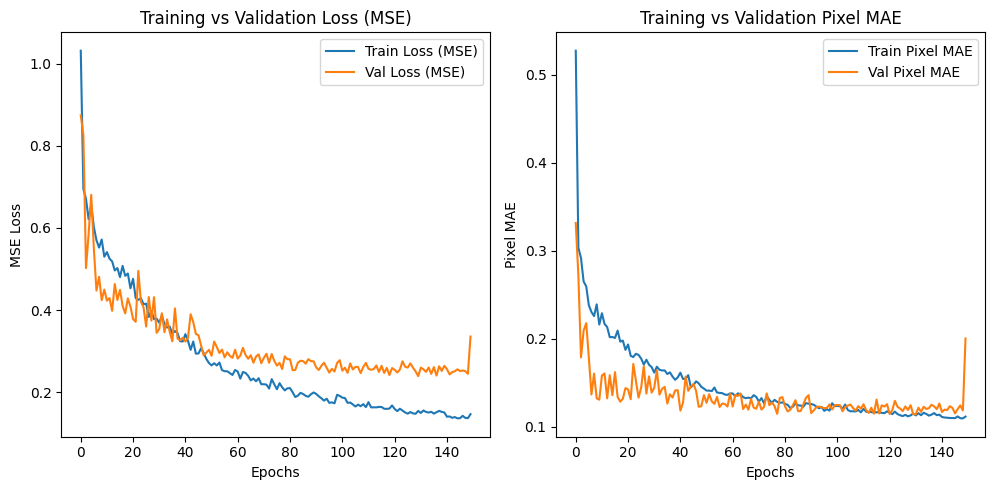

In [25]:
plt.figure(figsize=(15,5))

# loss (MSE)
plt.subplot(1,3,1)
plt.plot(history.history["loss"], label="Train Loss (MSE)")
plt.plot(history.history["val_loss"], label="Val Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss (MSE)")
plt.legend()

# pixel-wise MAE
plt.subplot(1,3,2)
plt.plot(history.history["mae"], label="Train Pixel MAE")
plt.plot(history.history["val_mae"], label="Val Pixel MAE")
plt.xlabel("Epochs")
plt.ylabel("Pixel MAE")
plt.title("Training vs Validation Pixel MAE")
plt.legend()

plt.tight_layout()
plt.show()

**Analysis**
* **MSE Loss**:

  * The **training loss** steadily decreases over epochs, indicating that the model is learning.
  * The **validation loss** also decreases at first but then stabilizes and remains slightly higher than the training loss.

* **Pixel MAE**:

  * Both training and validation MAE decrease over time.
  * Validation MAE follows the training MAE closely, suggesting the model generalizes reasonably well.

**Overfitting vs Underfitting**

* **Overfitting** occurs when the model performs very well on training data but poorly on validation data. In this case:

  * The training loss is lower than the validation loss, but the gap is **moderate**, not huge.
  * This indicates **mild overfitting**, which is normal in deep learning and can be controlled with regularization and early stopping.

* **Underfitting** occurs when both training and validation losses are high and the model cannot learn patterns effectively.

  * Here, the losses are **decreasing and relatively low**, so the model is **not underfitting**.

**Conclusion:** The model is learning well with slight overfitting, which can be further minimized using techniques like data augmentation, dropout, or fine-tuning the learning rate.




In [26]:
final_train_loss = history.history["loss"][-1]
final_val_loss = history.history["val_loss"][-1]

final_train_mae = history.history["mae"][-1]
final_val_mae = history.history["val_mae"][-1]

print(f"Final Train Loss (MSE): {final_train_loss:.4f}")
print(f"Final Val Loss (MSE):   {final_val_loss:.4f}")

print(f"Final Train Pixel MAE:  {final_train_mae:.4f}")
print(f"Final Val Pixel MAE:    {final_val_mae:.4f}")

Final Train Loss (MSE): 0.1460
Final Val Loss (MSE):   0.3353
Final Train Pixel MAE:  0.1115
Final Val Pixel MAE:    0.2004


In [28]:
# save full model
csrnet_model.save("CSRNet.keras")

# load saved model (no retraining needed)
loaded_model = tf.keras.models.load_model("CSRNet.keras")

# **Prediction**

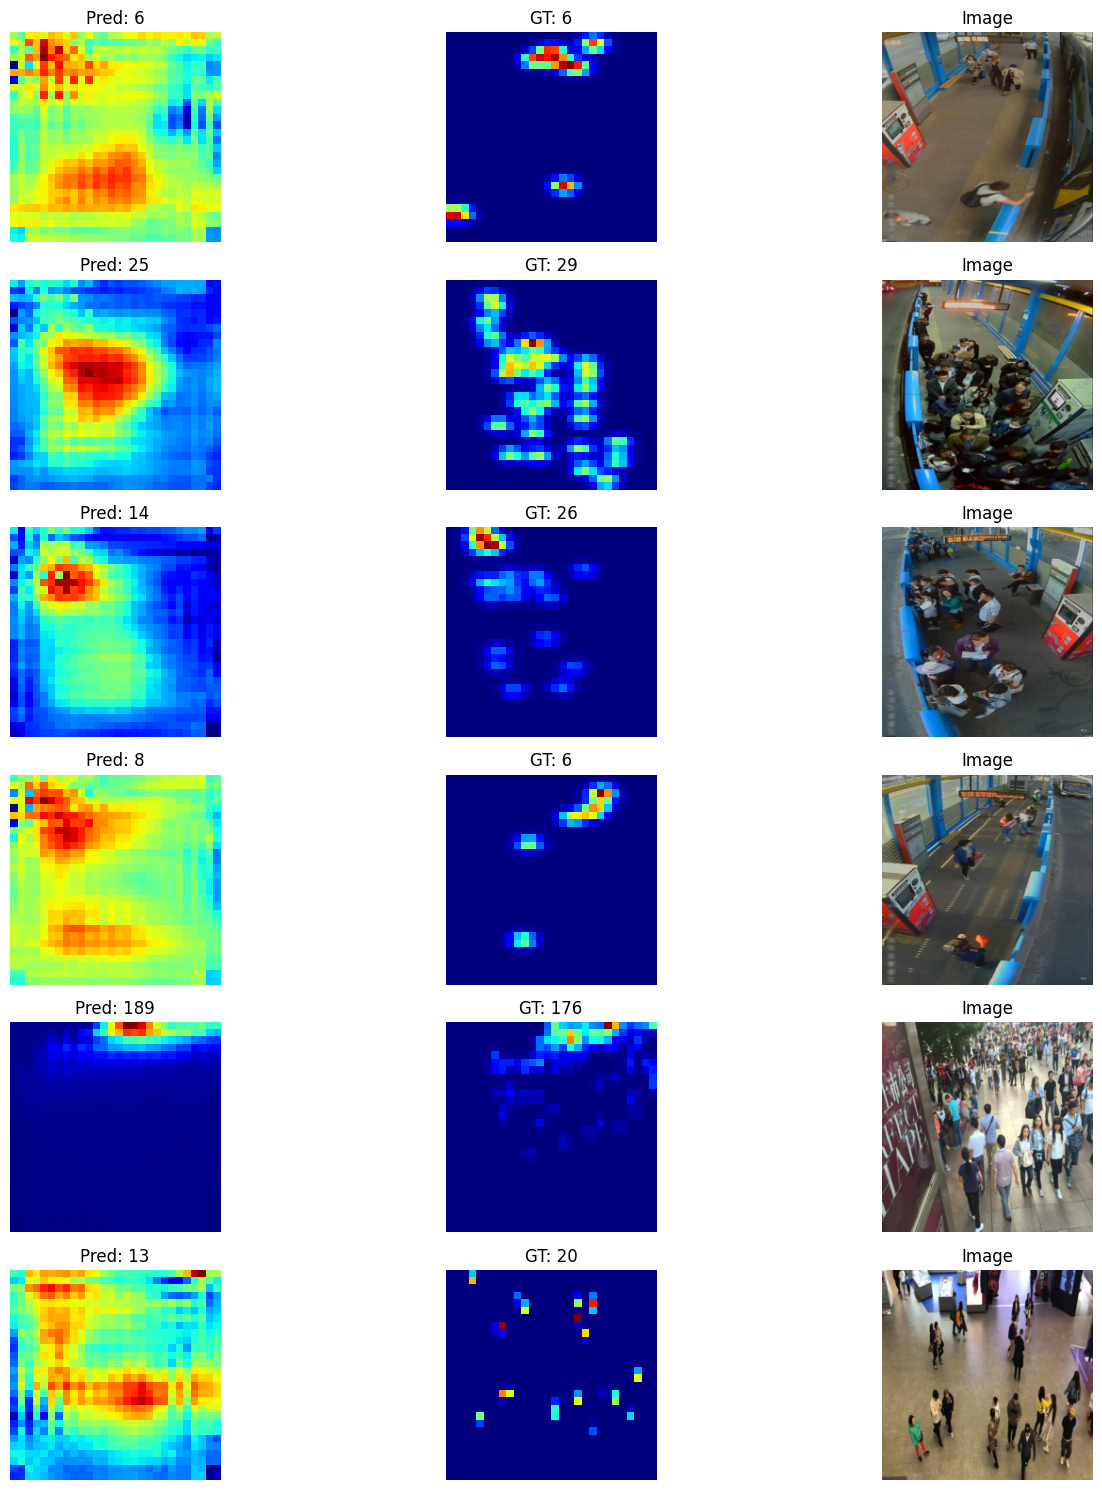

In [27]:
def visualize_multiple_predictions(model, images, density_maps, n_samples=6):
    idxs = np.random.choice(len(images), n_samples, replace=False)
    plt.figure(figsize=(15, 15))

    for i, idx in enumerate(idxs):
        image = images[idx]
        true_map = density_maps[idx, :, :, 0]

        # predict density map
        pred_map = model.predict(np.expand_dims(image, axis=0), verbose=0)[0, :, :, 0]

        # vounts
        pred_count = pred_map.sum()
        true_count = true_map.sum()

        # 3 rows (pred, ground truth, image)
        row_base = i * 3

        # predicted
        plt.subplot(n_samples, 3, row_base + 1)
        plt.imshow(pred_map, cmap='jet')
        plt.title(f"Pred: {int(pred_count)}")
        plt.axis("off")

        # ground truth
        plt.subplot(n_samples, 3, row_base + 2)
        plt.imshow(true_map, cmap='jet')
        plt.title(f"GT: {int(true_count)}")
        plt.axis("off")

        # original image
        plt.subplot(n_samples, 3, row_base + 3)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_multiple_predictions(csrnet_model, X_val, y_val, n_samples=6)

In [29]:
preds = csrnet_model.predict(test_ds)
counts = [pred.sum() for pred in preds]

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step


In [30]:
results = pd.DataFrame({
    "image_id": test_ids,
    "predicted_count": counts
})

results.to_csv("submission csr.csv", index=False)